In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory




import os

file_paths = []  # Dosya yollarını saklamak için bir liste

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# GEREKLİ KÜTÜPHANELERİN EKLENMESİ:

In [91]:

import os
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations import Blur, CLAHE, RandomRotate90
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# KULLANILACAK SINIFLARIN SEÇİLMESİ:

In [92]:
# Kaggle ortamında çalışma klasörlerini belirle
INPUT_PATH = "../input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
OUTPUT_PATH = "./processed_dataset"
TRAIN_PATH = "./processed_dataset/train"
TEST_PATH = "./processed_dataset/test"
AUGMENTED_PATH = "./processed_dataset/augmented"
MANIPULATED_PATH = "./processed_dataset/manipulated"
WB_PATH = "./processed_dataset/white_balanced"

selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
images_per_class = 650
image_size = (128, 128)  # Model giriş boyutu olarak örnektir.


# SEÇİLEN SINIFLARI YENİ KLASÖRE KOPYALAMA:

In [94]:
# 1. Adım: Seçilen sınıfları yeni bir klasöre kopyala
def prepare_dataset():
    if not os.path.exists(OUTPUT_PATH):
        os.makedirs(OUTPUT_PATH)

    for class_name in selected_classes:
        class_path = os.path.join(INPUT_PATH, class_name)
        target_class_path = os.path.join(OUTPUT_PATH, class_name)

        if not os.path.exists(target_class_path):
            os.makedirs(target_class_path)

        images = sorted(os.listdir(class_path))[:images_per_class]
        
        for img_name in images:
            src_img_path = os.path.join(class_path, img_name)
            dest_img_path = os.path.join(target_class_path, img_name)
            shutil.copy(src_img_path, dest_img_path)

# RESİMLERİ NORMALİZE ETME VE YENİDEN BOYUTLANDIRMA:

In [95]:
# 2. Adım: Resimleri normalize et ve yeniden boyutlandır
def preprocess_images():
    for class_name in selected_classes:
        class_path = os.path.join(OUTPUT_PATH, class_name)
        images = os.listdir(class_path)

        for img_name in tqdm(images, desc=f"Processing {class_name}"):
            img_path = os.path.join(class_path, img_name)

            # Resmi yükle ve boyutlandır
            image = cv2.imread(img_path)
            resized_image = cv2.resize(image, image_size)

            # Normalize et (0-1 aralığına getir)
            normalized_image = resized_image / 255.0

            # Yeni görüntüyü kaydet
            normalized_image = (normalized_image * 255).astype(np.uint8)
            cv2.imwrite(img_path, normalized_image)

# Kaggle Notebook'un çalışma alanında veri setini hazırla
prepare_dataset()
preprocess_images()

print("Veri seti işleme tamamlandı.")


Processing polar+bear: 100%|██████████| 650/650 [00:06<00:00, 105.60it/s]

Veri seti işleme tamamlandı.


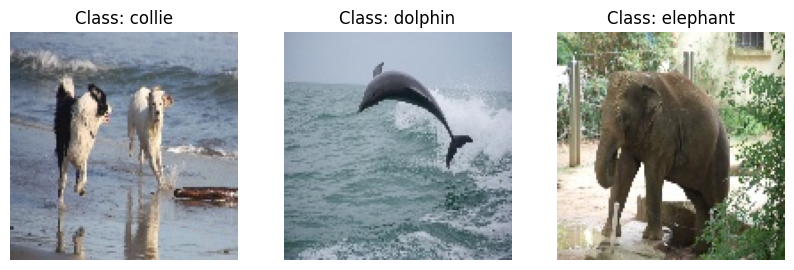

In [96]:
# 3. Adım: İşlenen resimlerden rastgele 3 tanesini göster
def display_random_images():
    random_images = []

    for class_name in selected_classes:
        class_path = os.path.join(OUTPUT_PATH, class_name)
        images = os.listdir(class_path)

        if len(images) > 0:
            random_images.append(os.path.join(class_path, np.random.choice(images)))
        if len(random_images) >= 3:
            break

    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(random_images):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis("off")
    plt.show()

display_random_images()

# VERİYİ TRAİN VE TEST OLARAK İKİYE AYIRMA:

In [97]:
def split_dataset():
    if not os.path.exists(TRAIN_PATH):
        os.makedirs(TRAIN_PATH)
    if not os.path.exists(TEST_PATH):
        os.makedirs(TEST_PATH)
  
    for class_name in selected_classes:
        class_path = os.path.join(OUTPUT_PATH, class_name)
        images = os.listdir(class_path)
        images = [os.path.join(class_path, img) for img in images]

        # Verileri %70 eğitim, %30 test olarak ayır
        train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

        train_class_path = os.path.join(TRAIN_PATH, class_name)
        test_class_path = os.path.join(TEST_PATH, class_name)

        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)
        if not os.path.exists(test_class_path):
            os.makedirs(test_class_path)

        for img_path in train_images:
            shutil.move(img_path, os.path.join(train_class_path, os.path.basename(img_path)))

        for img_path in test_images:
            shutil.move(img_path, os.path.join(test_class_path, os.path.basename(img_path)))


split_dataset()

print("Eğitim ve test setleri oluşturuldu.")


Eğitim ve test setleri oluşturuldu.


# VERİ ARTIRMA:

In [98]:
def augment_data():
    if not os.path.exists(AUGMENTED_PATH):
        os.makedirs(AUGMENTED_PATH)

    transform = A.Compose([
        Blur(blur_limit=3, p=0.2),
        CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
        RandomRotate90(p=0.5)
    ])

    for class_name in selected_classes:
        train_class_path = os.path.join(TRAIN_PATH, class_name)
        augmented_class_path = os.path.join(AUGMENTED_PATH, class_name)

        if not os.path.exists(augmented_class_path):
            os.makedirs(augmented_class_path)

        images = os.listdir(train_class_path)

        for img_name in tqdm(images, desc=f"Augmenting {class_name}"):
            img_path = os.path.join(train_class_path, img_name)
            image = cv2.imread(img_path)

            if image is not None:
                for i in range(3):  # Her resim için 3 farklı augmentasyon uygula
                    augmented = transform(image=image)
                    augmented_image = augmented["image"]
                    aug_img_name = f"aug_{i}_{img_name}"
                    cv2.imwrite(os.path.join(augmented_class_path, aug_img_name), augmented_image)

augment_data()

print("Veri artırma işlemi tamamlandı.")

Augmenting polar+bear: 100%|██████████| 455/455 [00:01<00:00, 351.36it/s]

Veri artırma işlemi tamamlandı.


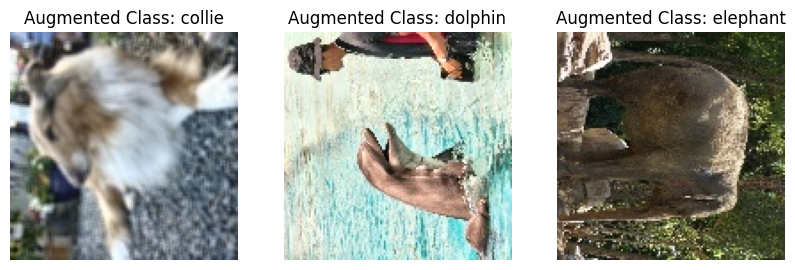

Augmented veriler görselleştirildi.


In [99]:
def display_augmented_images():
    random_images = []

    for class_name in selected_classes:
        augmented_class_path = os.path.join(AUGMENTED_PATH, class_name)
        images = os.listdir(augmented_class_path)

        if len(images) > 0:
            random_images.append(os.path.join(augmented_class_path, np.random.choice(images)))
        if len(random_images) >= 3:
            break

    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(random_images):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Augmented Class: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis("off")
    plt.show()

display_augmented_images()

print("Augmented veriler görselleştirildi.")

# CNN MODEL TASARIMI:

In [100]:
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # 10 sınıf için softmax
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return model

cnn_model = build_cnn_model()
cnn_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# Veri hazırlığı için Data Generator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical'
)

# Modeli eğit
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = cnn_model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    callbacks= [early_stopping],
    verbose=2
)

Found 4550 images belonging to 10 classes.
Found 1950 images belonging to 10 classes.
Epoch 1/5
143/143 - 101s - 709ms/step - accuracy: 0.1879 - loss: 2.1811 - val_accuracy: 0.2790 - val_loss: 2.0312
Epoch 2/5
143/143 - 108s - 757ms/step - accuracy: 0.3209 - loss: 1.8792 - val_accuracy: 0.4241 - val_loss: 1.7340
Epoch 3/5
143/143 - 112s - 781ms/step - accuracy: 0.4312 - loss: 1.6303 - val_accuracy: 0.5369 - val_loss: 1.4598
Epoch 4/5
143/143 - 99s - 691ms/step - accuracy: 0.4991 - loss: 1.4510 - val_accuracy: 0.5559 - val_loss: 1.3313
Epoch 5/5
143/143 - 99s - 690ms/step - accuracy: 0.5407 - loss: 1.3306 - val_accuracy: 0.5867 - val_loss: 1.2348


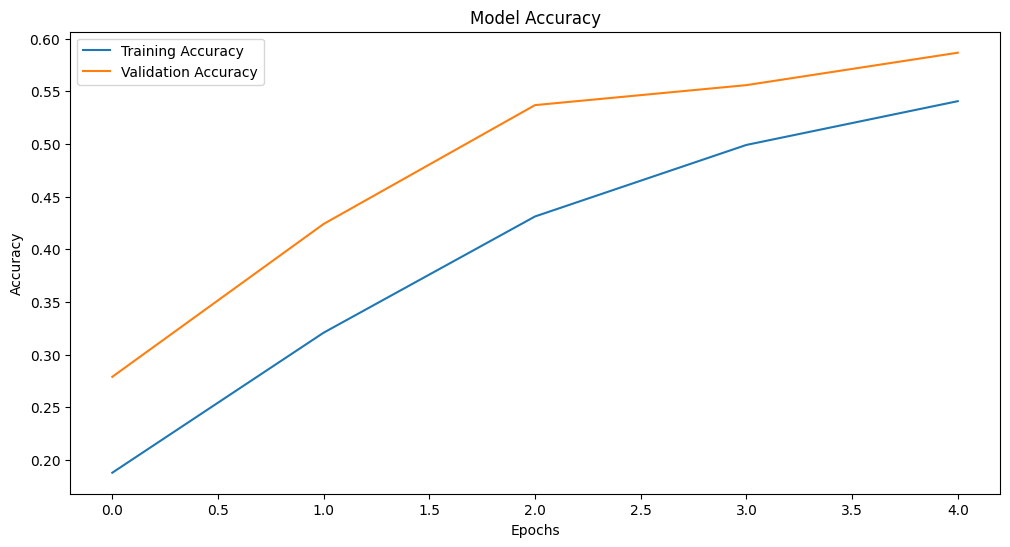

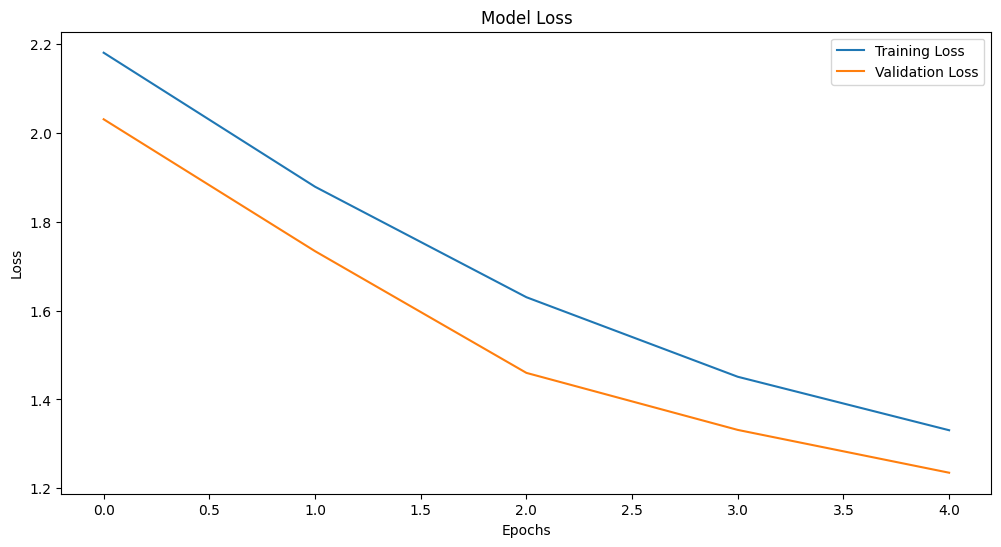

Modelin eğitimi ve görselleştirme işlemi tamamlandı.


In [103]:
# Eğitim ve doğrulama doğruluklarını görselleştir
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Eğitim ve doğrulama kayıplarını görselleştir
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Modelin eğitimi ve görselleştirme işlemi tamamlandı.")

61/61 - 11s - 177ms/step


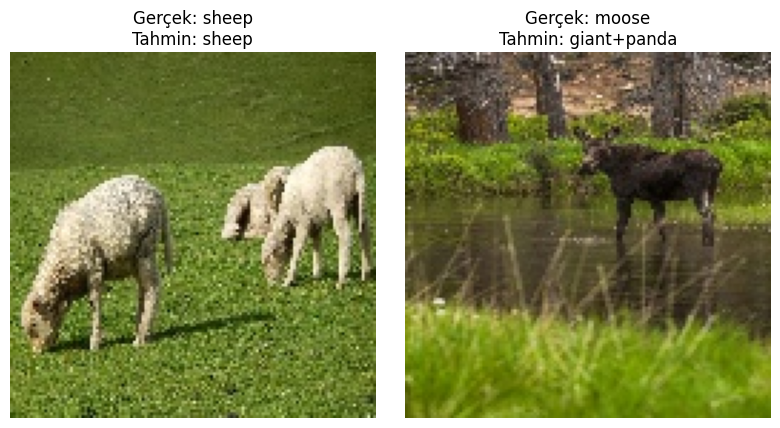

Model tahminleri görselleştirildi.


In [108]:

# Modelin Tahminlerinin Görselleştirilmesi
def visualize_predictions():
    # Tahminler ve Görselleştirme
    test_generator.reset()
    predictions = cnn_model.predict(test_generator, verbose=2)
    predicted_classes = np.argmax(predictions, axis=1)
    class_labels = list(test_generator.class_indices.keys())

    test_images, test_labels = next(iter(test_generator))

    plt.figure(figsize=(12, 12))
    for i in range(2):  # İlk 3 örneği görselleştirelim
        plt.subplot(3, 3, i + 1)
        plt.imshow(test_images[i])
        true_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[predicted_classes[i]]
        plt.title(f"Gerçek: {true_label}\nTahmin: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions()
print("Model tahminleri görselleştirildi.")

# RESİMLERİN FARKLI IŞIKLAR İLE MANİPÜLE EDİLMESİ:

In [109]:
# Resimlerin Farklı Işıklar ile Manipüle Edilmesi
def get_manipulated_images():
    if not os.path.exists(MANIPULATED_PATH):
        os.makedirs(MANIPULATED_PATH)

    transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.0)
    ])

    for class_name in selected_classes:
        class_path = os.path.join(TEST_PATH, class_name)
        manipulated_class_path = os.path.join(MANIPULATED_PATH, class_name)

        if not os.path.exists(manipulated_class_path):
            os.makedirs(manipulated_class_path)

        images = os.listdir(class_path)

        for img_name in tqdm(images, desc=f"Manipulating {class_name}"):
            img_path = os.path.join(class_path, img_name)
            image = cv2.imread(img_path)

            if image is not None:
                manipulated = transform(image=image)
                manipulated_image = manipulated["image"]
                manipulated_img_path = os.path.join(manipulated_class_path, img_name)
                cv2.imwrite(manipulated_img_path, manipulated_image)

get_manipulated_images()
print("Test resimleri manipüle edildi ve kaydedildi.")


Manipulating polar+bear: 100%|██████████| 195/195 [00:00<00:00, 844.34it/s]

Test resimleri manipüle edildi ve kaydedildi.


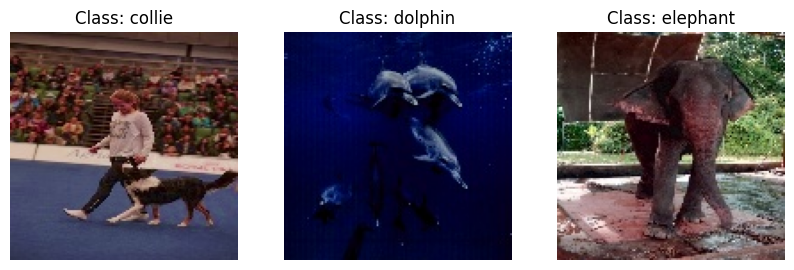

Manipüle edilmiş resimlerden örnekler gösterildi.


In [110]:
# Manipüle edilmiş resimlerden örnek göster

def display_manipulated_images():
    random_images = []

    for class_name in selected_classes:
        manipulated_class_path = os.path.join(MANIPULATED_PATH, class_name)
        images = os.listdir(manipulated_class_path)

        if len(images) > 0:
            random_images.append(os.path.join(manipulated_class_path, np.random.choice(images)))
        if len(random_images) >= 3:
            break

    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(random_images):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis("off")
    plt.show()

display_manipulated_images()
print("Manipüle edilmiş resimlerden örnekler gösterildi.")


In [112]:
# 11. Manipüle Edilmiş Test Seti ile Modelin Denenmesi
def evaluate_on_manipulated():
    manipulated_datagen = ImageDataGenerator(rescale=1./255)
    manipulated_generator = manipulated_datagen.flow_from_directory(
        MANIPULATED_PATH,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical'
    )
    loss, accuracy = cnn_model.evaluate(manipulated_generator, verbose=2)
    print(f"Manipüle edilmiş test seti - Loss: {loss}, Accuracy: {accuracy}")
    return accuracy

manipulated_accuracy = evaluate_on_manipulated()

Found 1950 images belonging to 10 classes.
61/61 - 10s - 169ms/step - accuracy: 0.5205 - loss: 1.4156
Manipüle edilmiş test seti - Loss: 1.415627360343933, Accuracy: 0.5205128192901611


# RENK SABİTLİĞİ ALGORİTMASI UYGULANMASI:

In [113]:
# 12. Renk Sabitliği Algoritması Uygulanması
def apply_white_balance():
    if not os.path.exists(WB_PATH):
        os.makedirs(WB_PATH)

    def gray_world(img):
        img = img.astype(np.float32)
        avg_r = np.mean(img[:, :, 2])
        avg_g = np.mean(img[:, :, 1])
        avg_b = np.mean(img[:, :, 0])
        avg_gray = (avg_r + avg_g + avg_b) / 3
        img[:, :, 2] *= avg_gray / avg_r
        img[:, :, 1] *= avg_gray / avg_g
        img[:, :, 0] *= avg_gray / avg_b
        return np.clip(img, 0, 255).astype(np.uint8)

    for class_name in selected_classes:
        manipulated_class_path = os.path.join(MANIPULATED_PATH, class_name)
        wb_class_path = os.path.join(WB_PATH, class_name)

        if not os.path.exists(wb_class_path):
            os.makedirs(wb_class_path)

        images = os.listdir(manipulated_class_path)

        for img_name in tqdm(images, desc=f"Applying WB to {class_name}"):
            img_path = os.path.join(manipulated_class_path, img_name)
            image = cv2.imread(img_path)

            if image is not None:
                wb_image = gray_world(image)
                wb_img_path = os.path.join(wb_class_path, img_name)
                cv2.imwrite(wb_img_path, wb_image)

apply_white_balance()
print("Renk sabitliği uygulandı ve kaydedildi.")

Applying WB to polar+bear: 100%|██████████| 195/195 [00:00<00:00, 1199.19it/s]

Renk sabitliği uygulandı ve kaydedildi.


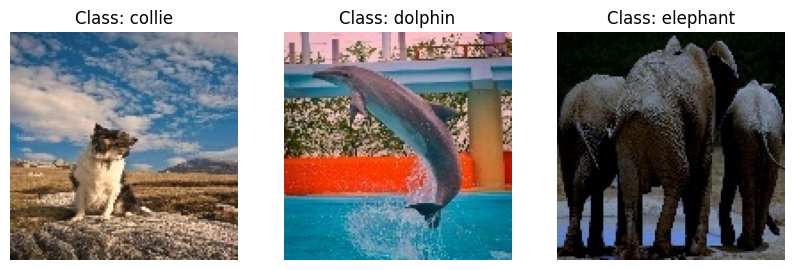

Renk sabitliği uygulanmış resimlerden örnekler gösterildi.


In [114]:
# Renk sabitliği uygulanmış resimlerden örnek göster

def display_white_balanced_images():
    random_images = []

    for class_name in selected_classes:
        wb_class_path = os.path.join(WB_PATH, class_name)
        images = os.listdir(wb_class_path)

        if len(images) > 0:
            random_images.append(os.path.join(wb_class_path, np.random.choice(images)))
        if len(random_images) >= 3:
            break

    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(random_images):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis("off")
    plt.show()

display_white_balanced_images()
print("Renk sabitliği uygulanmış resimlerden örnekler gösterildi.")

In [115]:
# 13. Renk Sabitliği Uygulanmış Test Seti ile Modelin Denenmesi
def evaluate_on_white_balanced():
    wb_datagen = ImageDataGenerator(rescale=1./255)
    wb_generator = wb_datagen.flow_from_directory(
        WB_PATH,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical'
    )
    loss, accuracy = cnn_model.evaluate(wb_generator, verbose=2)
    print(f"Renk sabitliği uygulanmış test seti - Loss: {loss}, Accuracy: {accuracy}")
    return accuracy

wb_accuracy = evaluate_on_white_balanced()

Found 1950 images belonging to 10 classes.
61/61 - 11s - 178ms/step - accuracy: 0.4344 - loss: 1.7021
Renk sabitliği uygulanmış test seti - Loss: 1.702065348625183, Accuracy: 0.43435898423194885


# SONUÇLARIN KARŞILAŞTIRILMASI:

In [117]:
# 14. Sonuçların Karşılaştırılması ve Raporlama
def report_results():
    original_datagen = ImageDataGenerator(rescale=1./255)
    original_generator = original_datagen.flow_from_directory(
        TEST_PATH,
        target_size=image_size,
        batch_size=32,
        class_mode='categorical'
    )
    original_loss, original_accuracy = cnn_model.evaluate(original_generator, verbose=2)

    print("\n--- Test Set Sonuçları ---")
    print(f"Orijinal Test Seti - Accuracy: {original_accuracy}")
    print(f"Manipüle Edilmiş Test Seti - Accuracy: {manipulated_accuracy}")
    print(f"Renk Sabitliği Uygulanmış Test Seti - Accuracy: {wb_accuracy}")

report_results()
print("Sonuçlar karşılaştırıldı ve raporlandı.")

Found 1950 images belonging to 10 classes.
61/61 - 10s - 168ms/step - accuracy: 0.5867 - loss: 1.2348

--- Test Set Sonuçları ---
Orijinal Test Seti - Accuracy: 0.5866666436195374
Manipüle Edilmiş Test Seti - Accuracy: 0.5205128192901611
Renk Sabitliği Uygulanmış Test Seti - Accuracy: 0.43435898423194885
Sonuçlar karşılaştırıldı ve raporlandı.
